<a href="https://colab.research.google.com/github/itsmeeeeeee/Probing_Bert/blob/main/probing_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probing BERT for Animacy Understanding



#**Dataset**
1- Load the Datset from Hugging Face

2- Format of the Dataset

3- Annotate the Dataset for Animacy Using WordNet



In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import wordnet as wn
from datasets import load_dataset



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# download wordnet from nltk
nltk.download('wordnet')


Mounted at /content/drive


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Load the dataset from HuggingFace
ds = load_dataset("Cyberfish/pos_tagger")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/198796 [00:00<?, ? examples/s]

In [ ]:
# Function to get hypernyms recursively
def get_hypernyms(synset):
    hypernyms = set()
    for hypernym in synset.hypernyms():
        hypernyms |= set(get_hypernyms(hypernym))
    return hypernyms | set(synset.hypernyms())

# Function to extract hypernyms from WordNet
def extract_hypernyms(w):
    hypernyms_ = []
    synsets = wn.synsets(str(w), pos=wn.NOUN)
    if len(synsets) != 0:
        word = synsets[0]
        hypernyms = get_hypernyms(word)
        for hypernym in hypernyms:
            hypernyms_.append(hypernym.lemma_names('eng')[0])
    return hypernyms_

# Function to label animate and inanimate
def label_animate(hypernyms):
    if type(hypernyms) != float:
        if len(hypernyms) == 0:
            return "wordnet_false"
        if "living_thing" not in hypernyms:
            return "inanimate"
        else:
            return "animate"

def get_numeric_label(label):
    if label == "animate":
        return 1
    elif label == "inanimate":
        return 0
    return None  # None for "other POS"

In [ ]:
data = []

current_sentence = []
sentence_no =

for item in ds['train']:
    word, tag = item['text'].split('/')
    current_sentence.append((word, tag))  # Speichern des Wortes und des POS-Tags

    if tag == '.':
        sentence = ' '.join(word for word, _ in current_sentence)

        # Hinzufügen jedes Wortes und des zugehörigen POS-Tags zum Datensatz
        for word, pos in current_sentence:
            hypernyms = ""
            label = "other POS"
            if pos in ['NN', 'NNS', 'NNP', 'NNPS']:
                hypernyms = extract_hypernyms(word)
                label = label_animate(hypernyms) if hypernyms else "not recognized"
            else:
                label = "other POS"

            numeric_label = get_numeric_label(label)
            data.append([sentence, sentence_no, word, pos, hypernyms, label, numeric_label])

        current_sentence = []
        sentence_no += 1

# Erstellen des DataFrames
df_labeled = pd.DataFrame(data, columns=['Sentence', 'Sentence_no', 'Word', 'POS', 'Hypernyms', 'Label', 'Numeric_Label'])

In [ ]:
df_labeled.head(10)


,Sentence,Sentence_no,Word,POS,Hypernyms,Label,Numeric_Label
0,"Newsweek , trying to keep pace with rival Time...",0,Newsweek,NNP,[],not recognized,NaN
1,"Newsweek , trying to keep pace with rival Time...",0,",",",",,other POS,NaN
2,"Newsweek , trying to keep pace with rival Time...",0,trying,VBG,,other POS,NaN
3,"Newsweek , trying to keep pace with rival Time...",0,to,TO,,other POS,NaN
4,"Newsweek , trying to keep pace with rival Time...",0,keep,VB,,other POS,NaN
5,"Newsweek , trying to keep pace with rival Time...",0,pace,NN,"[entity, relation, magnitude_relation, rate, a...",inanimate,0.0
6,"Newsweek , trying to keep pace with rival Time...",0,with,IN,,other POS,NaN
7,"Newsweek , trying to keep pace with rival Time...",0,rival,JJ,,other POS,NaN
8,"Newsweek , trying to keep pace with rival Time...",0,Time,NNP,"[happening, case, event, entity, abstraction, ...",inanimate,0.0
9,"Newsweek , trying to keep pace with rival Time...",0,magazine,NN,"[object, entity, press, print_media, work, art...",inanimate,0.0


In [ ]:
df_labeled[27:]

,Sentence,Sentence_no,Word,POS,Hypernyms,Label,Numeric_Label
27,"Newsweek , trying to keep pace with rival Time...",0,advertisers,NNS,"[physical_entity, person, entity, publicist, l...",animate,1.0


# **Tokenization and Embedding Extraction**


In [ ]:
!pip install transformers

## **Tokenization:**
 In this section, functions for tokenization are defined. Subtokens are handled for each token. To extract embeddings, the main token is applied.




In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval
from transformers import BertTokenizer, BertModel, AutoTokenizer
import torch
from pathlib import Path
from typing import Dict

In [ ]:

model_ckpt = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
tokenized_input = tokenizer("The upside was in the intangible real estate ... which is no longer an intangible .")
print(tokenized_input)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens


{'input_ids': [101, 1109, 16888, 1108, 1107, 1103, 1107, 5108, 12192, 1842, 3327, 119, 119, 119, 1134, 1110, 1185, 2039, 1126, 1107, 5108, 12192, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


['[CLS]',
 'The',
 'upside',
 'was',
 'in',
 'the',
 'in',
 '##tan',
 '##gible',
 'real',
 'estate',
 '.',
 '.',
 '.',
 'which',
 'is',
 'no',
 'longer',
 'an',
 'in',
 '##tan',
 '##gible',
 '.',
 '[SEP]']

In [ ]:

# Returns a list of lists of indices for each subtoken from the tokenizer, if more than one subtoken appears
def get_indexof_subtokens(tokenizer_output):
    result = []
    temp_liste = [tokenizer_output[0]]  # Start with the first word in the temporary list

    for i in range(1, len(tokenizer_output)):
        # If the current word has the same property as the previous word
        if tokenizer_output[i][:2] == "##" and tokenizer_output[i - 1][:2] == "##":
            temp_liste.append(i)

        else:
            if len(temp_liste) > 1:  # If the temporary list contains more than one word, add it to the result.
                result.append(temp_liste)
            temp_liste = [i]  # Start a new temporary list with the current word.

    # Add the last temporary list to the result if it contains more than one word
    if len(temp_liste) > 1:
        result.append(temp_liste)

    return result

ll = ['[CLS]',
 'News',
 '##week',
 ',',
 'trying',
 'to',
 'Keep',
 'pace',
 'with',
 'rival',
 'Time',
 'magazine',
 ',',
 'announced',
 'new',
 'advertising',
 'rates',
 'for',
 '1990',
 'and',
 'said',
 'it',
 'will',
 'introduce',
 'a',
 'new',
 'incentive',
 'plan',
 'for',
 'ad',
 '##vert',
 '##isers',
 '.',
 '[SEP]']

get_indexof_subtokens(ll)

[[30, 31]]

In [ ]:
"""Returns three lists: one list with main words (only those tokenized into a single subword),
   one with subword related to the main word, and one list with tokenizer indices of the main words.
    All three lists are of the same length"""

def get_main_token_subtoken_embed_index(tokens):
    main_token = []
    subtoken = []
    embed_index_main_token = []

    for i in range(len(tokens) - 1):
        s = ""
        if "##" in tokens[i] and "##" not in tokens[i - 1] and "##" not in tokens[i + 1]:
            s += tokens[i - 1]
            subtoken.append(tokens[i])
            s += tokens[i]
            embed_index_main_token.append(i - 1)


        main_token.append(s.replace("##", ""))
    main_token = [x for x in main_token if x != ""]
    return main_token, subtoken, embed_index_main_token


ll = ['[CLS]',
 'News',
 '##week',
 ',',
 'trying',
 'to',
 'Keep',
 'pace',
 'with',
 'rival',
 'Time',
 'magazine',
 ',',
 'announced',
 'new',
 'advertising',
 'rates',
 'for',
 '1990',
 'and',
 'said',
 'it',
 'will',
 'introduce',
 'a',
 'new',
 'incentive',
 'plan',
 'for',
 'ad',
 '##vert',
 '##isers',
 '.',
 '[SEP]']

main_token, subtoken, embed_index = get_main_token_subtoken_embed_index(ll)
print(main_token)
print(subtoken)
print(embed_index)

['Newsweek']
['##week']
[1]


In [ ]:
"""Returns three lists: one list with main words (only those tokenized into multi subwords),
   one with list of subwords related to the main words, and one list with tokenizer indices of the main words.
    All three lists are of the same length"""

def get_main_tokens_subtokens_embed_index(tokenizer_output):
    index_subtokens = get_indexof_subtokens(tokenizer_output)
    main_words = []
    subwords = []
    embed_index = []
    s = ""
    for inds in index_subtokens:
        #print(".......",res[0]-1)
        s += tokenizer_output[inds[0] - 1]
        l = []
        for ind in inds:
            l.append(tokenizer_output[ind])

            s += tokenizer_output[ind]
        subwords.append(l)
        main_words.append(s.replace("##", ""))
        s = ""
        embed_index.append(inds[0] - 1)

    return main_words, subwords, embed_index


ll = ['[CLS]',
 'The',
 'upside',
 'was',
 'in',
 'the',
 'in',
 '##tan',
 '##gible',
 'real',
 'estate',
 '.',
 '.',
 '.',
 'which',
 'is',
 'no',
 'longer',
 'an',
 'in',
 '##tan',
 '##gible',
 '.',
 '[SEP]']

main_words, subwords, embed_index = get_main_tokens_subtokens_embed_index(ll)
print(main_words)
print(subwords)  #teilwort,embed_index)
print(embed_index)

['intangible', 'intangible']
[['##tan', '##gible'], ['##tan', '##gible']]
[6, 19]


##**Tokensize the corpus and extract Embeddings**

In [ ]:
end_data = df_labeled["Sentence"].tolist()
texts_ohne_dublikate = pd.Series(end_data).drop_duplicates().tolist()

In [ ]:
import time
start_time = time.time()


all_main_tokens = []
all_subtokens = []
all_embeded_index = []
all_tokens = []
all_contextualized_vectors= []

for ind, el in enumerate(texts_ohne_dublikate):
  tokenized_input = tokenizer(el)
  tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
  main_tokens, subtokens, embed_index_main_tokens= get_main_tokens_subtokens_embed_index(tokens)
  main_token, subtoken, embed_index_main_token = get_main_token_subtoken_embed_index(tokens)
  main_tokens += main_token
  subtokens += subtoken
  embed_index_main_tokens += embed_index_main_token
  all_tokens.append(tokens)
  all_main_tokens.append(main_tokens)
  all_subtokens.append(subtokens)
  all_embeded_index.append(embed_index_main_tokens)
  input_vectors = []
  with torch.no_grad():
        outputs = model(torch.tensor(tokenized_input["input_ids"]).unsqueeze(0))
        contextualized_vectors = outputs.last_hidden_state
        for el in contextualized_vectors:
          all_contextualized_vectors.append(el)



  print(f"""##########################################################################
############################# new element {ind} ##############################
########################################################################""")
elapsed_time_seconds = time.time() - start_time
elapsed_time_minutes = elapsed_time_seconds / 60

print(f"Der Code hat {elapsed_time_minutes:.2f} Minuten gedauert.")
  #print(tokens)
  #print(main_token,subtoken, embed_index_main_token)


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
########################################################################
##########################################################################
############################# new element 6469 ##############################
########################################################################
##########################################################################
############################# new element 6470 ##############################
########################################################################
##########################################################################
############################# new element 6471 ##############################
########################################################################
##########################################################################
############################# new element 6472 ##############################
#############################

In [ ]:
# Initializes the three new columns

df_labeled['subword'] = None
df_labeled['word_index'] = None
df_labeled['contextualized_vectors'] = None

In [ ]:
"""
    We iterate through the dataframe using a for loop. For all rows that have the same sentence,
    we define a dictionary called 'word_already_seen', so that words that appear more than once
    in a sentence don't receive the same index,
    but rather a unique index.

"""


def find_index_2(curr_word: str, sub_tokens: list, already_seen: Dict):
    last_index = already_seen.get(curr_word, 0)
    curr_index = sub_tokens.index(curr_word, last_index + 1)
    already_seen[curr_word] = curr_index
    return curr_index

In [ ]:
import traceback

"""This function is the main function for assigning 'subwords', word_index,
and contextualized vectors to each word in the dataframe."""


old_sentence_list = ""
counter = -1
hauptworter_fuer_current_satz = []
teilwoerter_fuer_current_satz = []
embed_index_fuer_current_satz = []
tokens_fuer_current_satz = []
previous_tokens = []
previous_sentence_no = None
word_already_seen = Dict

tensor_output = []
for index, row in df_labeled.iterrows():
    sentence_list = row["Sentence"]


     #Search for the index in 'texts_without_duplicates'. This is important because it corresponds to the
     #index for contextualized vectors, subwords, main_words, and EmbeddingIndex


    index_of_Sentence = texts_ohne_dublikate.index(sentence_list)
    tokens_fuer_current_satz = all_tokens[index_of_Sentence]

    hauptworter_fuer_current_satz =all_main_tokens[index_of_Sentence]
    teilwoerter_fuer_current_satz = all_subtokens[index_of_Sentence]
    embed_index_fuer_current_satz = all_embeded_index[index_of_Sentence]
    sentence_no_fuer_current_satz = row['Sentence_no']
    contextualized_vectors_fuer_current_satz = all_contextualized_vectors[index_of_Sentence]

    #When we come across a new sentence or the same sentence with a different sentence number,
    #the 'word_already_seen' is emptied


    if previous_tokens != tokens_fuer_current_satz or previous_sentence_no != sentence_no_fuer_current_satz:
        #print(f"changing from S_no:{previous_sentence_no} to-> S_no:{sentence_no_fuer_current_satz}")
        word_already_seen = dict()
    current_word = row['Word']
    index_of_word = -1
    if current_word in hauptworter_fuer_current_satz:
        index_of_hauptwort = hauptworter_fuer_current_satz.index(current_word)
        df_labeled.at[index, 'subword'] = teilwoerter_fuer_current_satz[index_of_hauptwort]
        index_of_word = embed_index_fuer_current_satz[index_of_hauptwort]
        df_labeled.at[index, "word_index"] = index_of_word

    elif current_word in tokens_fuer_current_satz:
        try:
            index_of_word = find_index_2(current_word, tokens_fuer_current_satz, word_already_seen)
        except Exception as e:
            print(f"""*****************************************************************************
********************************** index {index} *******************************************
*************************************************************************************""")
            #print(index)
            #print("current_word", current_word)
            #print("tokens_fuer_current_satz:")
            #print(tokens_fuer_current_satz)
            #print("word already seen")
            #print(word_already_seen)
            traceback.print_exc()
            break
        df_labeled.at[index, "word_index"] = index_of_word

    if index_of_word != -1:

        # If 'current_word' appears in main_word or in 'tokens', then the index must be a value that is >= 0

        e = contextualized_vectors_fuer_current_satz[index_of_word].tolist()
        tensor_output.append(e)

    else:
        tensor_output.append(None)

    previous_tokens = tokens_fuer_current_satz
    previous_sentence_no = sentence_no_fuer_current_satz

    #print("hallo there")

df_labeled['contextualized_vectors'] = tensor_output

# Filtered by end labels (only 0 and 1 labels are taken)
filtered_endlabels=df_labeled[(df_labeled["Numeric_Label"] >= 0.0) & (df_labeled["Numeric_Label"] <= 1.0)]

#  The NaN values from the "contextualized_vectors" are removed
filtered_endlabels.dropna(subset=["contextualized_vectors"],inplace=True)

# Due to the sentences repeating themselves in the dataset, similar embedding vectors are remove
end_embedding = filtered_endlabels.drop_duplicates(subset="contextualized_vectors")

elapsed_time_seconds = time.time() - start_time
elapsed_time_minutes = elapsed_time_seconds / 60

print(f"Der Code hat {elapsed_time_minutes:.2f} Minuten gedauert.")

#Save data
end_embedding.to_csv("/content/drive/My Drive/probing_llm/embeddings_nouns.csv")
print("saved")



<ipython-input-41-899df6cd218b>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_endlabels.dropna(subset=["contextualized_vectors"],inplace=True)


Der Code hat 38.53 Minuten gedauert.
saved


# **Read the end data**

In [ ]:
file_path_data ="/content/drive/My Drive/probing_llm/embeddings_nouns.csv"
end_data = pd.read_csv(file_path_data)

In [ ]:
end_data.shape

(45427, 11)

In [ ]:
end_data


,Unnamed: 0,Sentence,Sentence_no,Word,POS,Hypernyms,Label,Numeric_Label,subword,word_index,contextualized_vectors
0,5,"Newsweek , trying to keep pace with rival Time...",0,pace,NN,"['entity', 'relation', 'magnitude_relation', '...",inanimate,0.0,NaN,7.0,"[-0.1420280784368515, 0.8476762771606445, -0.1..."
1,8,"Newsweek , trying to keep pace with rival Time...",0,Time,NNP,"['happening', 'case', 'event', 'entity', 'abst...",inanimate,0.0,NaN,10.0,"[-0.5077092051506042, 0.4742615818977356, 0.35..."
2,9,"Newsweek , trying to keep pace with rival Time...",0,magazine,NN,"['object', 'entity', 'press', 'print_media', '...",inanimate,0.0,NaN,11.0,"[-0.16969908773899078, 0.5319728851318359, 0.0..."
3,13,"Newsweek , trying to keep pace with rival Time...",0,advertising,NN,"['message', 'promotion', 'entity', 'communicat...",inanimate,0.0,NaN,15.0,"[0.6472041606903076, 0.5184727311134338, 0.548..."
4,14,"Newsweek , trying to keep pace with rival Time...",0,rates,NNS,"['levy', 'entity', 'possession', 'relation', '...",inanimate,0.0,NaN,16.0,"[-0.13533198833465576, 0.43440839648246765, 0...."
...,...,...,...,...,...,...,...,...,...,...,...
45422,198771,"Still , massive internal debt has forced the g...",8193,market,NN,"['act', 'event', 'entity', 'activity', 'abstra...",inanimate,0.0,NaN,17.0,"[0.027194354683160782, 0.23446138203144073, -0..."
45423,198776,"Still , massive internal debt has forced the g...",8193,returns,NNS,"['written_communication', 'legal_document', 'e...",inanimate,0.0,NaN,24.0,"[0.06672365963459015, 0.6268224716186523, 0.41..."
45424,198784,"Still , massive internal debt has forced the g...",8193,month,NN,"['entity', 'time_period', 'fundamental_quantit...",inanimate,0.0,NaN,32.0,"[-0.4563648998737335, -0.37470436096191406, 0...."
45425,198788,"Still , massive internal debt has forced the g...",8193,investors,NNS,"['physical_entity', 'capitalist', 'person', 'e...",animate,1.0,NaN,36.0,"[0.31645238399505615, 0.3156405985355377, 0.30..."


In [ ]:
# Zählen, wie oft das Label "animate" vorkommt
animate_count = (end_data['Label'] == 'animate').sum()

print("Anzahl der 'animate' Labels:", animate_count)


Anzahl der 'animate' Labels: 6134


In [ ]:
# Zählen, wie oft das Label "animate" vorkommt
animate_count = (end_data['Label'] == 'inanimate').sum()

print("Anzahl der 'animate' Labels:", animate_count)

Anzahl der 'animate' Labels: 39293


# **Probing**

##MLP Classifier

In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval
import ast
from transformers import BertModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# reprocessing Step
# Standardize input features
scaler = StandardScaler()

# Convert string representations of vectors into a numpy array
X = np.vstack(end_data['contextualized_vectors'].apply(literal_eval))

# Standardize the features to have zero mean and unit variance
X = scaler.fit_transform(X)

In [ ]:
samples=len(X)

# Create an array of indices ranging from 0 to the number of samples - 1
indicies=np.arange(samples)
end_data.index=indicies

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(X, end_data['Numeric_Label'], indicies, test_size=0.2, random_state=42)

In [ ]:

# MLP-Classifier for binary classification
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(MLPClassifier, self).__init__()
        self.layers = nn.ModuleList()

        # Create hidden layers
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(input_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            input_dim = hidden_dim

        # Output layer
        self.output_layer = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.sigmoid(self.output_layer(x))
        return x

# Parameters
input_dim = X_train.shape[1]
hidden_dims = [100, 50]
learning_rate = 0.01
epochs = 40

# Initialize model
model = MLPClassifier(input_dim, hidden_dims)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Convert training data into tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')


Epoch 1/40, Loss: 0.7477607727050781
Epoch 2/40, Loss: 0.43597137928009033
Epoch 3/40, Loss: 0.2867661118507385
Epoch 4/40, Loss: 0.2001565545797348
Epoch 5/40, Loss: 0.16239021718502045
Epoch 6/40, Loss: 0.1417631059885025
Epoch 7/40, Loss: 0.13181409239768982
Epoch 8/40, Loss: 0.12235113978385925
Epoch 9/40, Loss: 0.10942158848047256
Epoch 10/40, Loss: 0.10447486490011215
Epoch 11/40, Loss: 0.09618883579969406
Epoch 12/40, Loss: 0.09319406747817993
Epoch 13/40, Loss: 0.08513179421424866
Epoch 14/40, Loss: 0.08114901185035706
Epoch 15/40, Loss: 0.0751563310623169
Epoch 16/40, Loss: 0.07271746546030045
Epoch 17/40, Loss: 0.06795425713062286
Epoch 18/40, Loss: 0.06557751446962357
Epoch 19/40, Loss: 0.06036560982465744
Epoch 20/40, Loss: 0.05778222158551216
Epoch 21/40, Loss: 0.05342117324471474
Epoch 22/40, Loss: 0.051833007484674454
Epoch 23/40, Loss: 0.04815144091844559
Epoch 24/40, Loss: 0.04625638574361801
Epoch 25/40, Loss: 0.04280196130275726
Epoch 26/40, Loss: 0.04079516977071762

#MLP Evaluate WITH ACC, F1 and CM

In [ ]:
import torch
from sklearn.metrics import f1_score

# # Convert test set into tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Evaluation
with torch.no_grad():  # Gradienten nicht berechnen
    test_outputs = model(X_test_tensor).squeeze()

  # Apply threshold for binary classification (>= 0.5 is classified as 1, else 0)
    predicted_labels = (test_outputs > 0.5).float()
    accuracy = (predicted_labels == y_test_tensor).float().mean()

print("Accuracy: ", accuracy.item())

# NumPy-Arrays für den F1-Score
predicted_labels_np = predicted_labels.numpy()
y_test_np = y_test_tensor.numpy()

# F1-Score
f1_custom_nn = f1_score(y_test_np, predicted_labels_np)
print("F1-Score: ", f1_custom_nn)


Accuracy:  0.9775478839874268
F1-Score:  0.9157024793388431


Confusion Matrix for MLP:


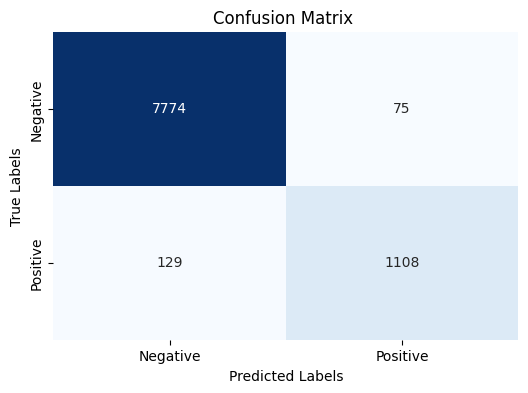

In [ ]:
# Confusion Matrix for Custom Neural Network
confusion = confusion_matrix(y_test, predicted_labels)

print("Confusion Matrix for MLP:")
#print(confusion)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix ')
plt.show()


- Inanimate (0): correct 7774, incorrect:75
- Animate (1): correct 1108, incorrect:1129

##Cosine Similarity

In [ ]:
# Standardize input features
scaler = StandardScaler()
X = np.vstack(end_data['contextualized_vectors'].apply(literal_eval))
X = scaler.fit_transform(X)

samples=len(X)
indicies=np.arange(samples)
end_data.index=indicies

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(X, end_data['Numeric_Label'], indicies, test_size=0.2, random_state=42)

In [ ]:
# Extract contextualized vectors
#c_vectors = df_embedding["contextualized_vectors"]

# Predict nouns and compare with true labels
test_d = end_data.loc[indices_test, :]

In [ ]:
test_d['contextualized_vectors'] = test_d['contextualized_vectors'].apply(literal_eval)

In [ ]:
import numpy as np
import torch
from transformers import BertTokenizer, BertModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity

# Lade BERT Tokenizer und Modell
model_ckpt = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)

In [ ]:

def generate_bert_label_embedding(label):
    embed_livingthing=[]
    if label in ["animate"]:
      with torch.no_grad():
          inputs_animate = tokenizer("living_thing")
          #tokens_animate = tokenizer.convert_ids_to_tokens(inputs_animate["input_ids"])
          outputs_animate = model(torch.tensor(inputs_animate["input_ids"]).unsqueeze(0))
          contextualized_vectors_animate = outputs_animate.last_hidden_state.numpy()
          return contextualized_vectors_animate[0][1]


    else:
      with torch.no_grad():
          inputs_inanimate = tokenizer("non-living_thing")
          #tokens_animate = tokenizer.convert_ids_to_tokens(inputs_animate["input_ids"])
          outputs_inanimate = model(torch.tensor(inputs_inanimate["input_ids"]).unsqueeze(0))
          contextualized_vectors_inanimate = outputs_inanimate.last_hidden_state.numpy()
          return contextualized_vectors_inanimate[0][1]


test_d['label embedding'] = test_d['Label'].apply(generate_bert_label_embedding)


In [ ]:
test_d['label embedding'] = test_d['label embedding'].apply(lambda x: x.tolist())

In [ ]:
# calculate cosine similarity
def calculate_cosine_similarity(row):
    vector_a = np.array(row['contextualized_vectors']).reshape(1, -1)
    vector_b = np.array(row['label embedding']).reshape(1, -1)

    similarity = cosine_similarity(vector_a, vector_b)

    return similarity[0][0]

test_d['cosine_similarity'] = test_d.apply(calculate_cosine_similarity, axis=1)

In [ ]:
test_d #Save data
test_d.to_csv("/content/drive/My Drive/probing_llm/test_data_cosine.csv")
print("saved")

saved


In [ ]:
test_d.head()

,Unnamed: 0,Sentence,Sentence_no,Word,POS,Hypernyms,Label,Numeric_Label,subword,word_index,contextualized_vectors,label embedding,cosine_similarity
18503,80221,An index of economic activity drawn from the s...,3285,reading,NN,"['process', 'entity', 'higher_cognitive_proces...",inanimate,0.0,NaN,20.0,"[0.24379123747348785, 0.41305115818977356, 0.3...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.397710
34649,151509,A report late yesterday that the Chicago-area ...,6222,country,NN,"['entity', 'group', 'political_unit', 'organiz...",inanimate,0.0,NaN,22.0,"[-0.413516104221344, -0.48201456665992737, -0....","[0.6329518556594849, -0.2643161118030548, -0.0...",0.519500
42718,186837,New York Mr. Wanniski 's opportuning of the re...,7673,reasoning,NN,"['process', 'entity', 'thinking', 'higher_cogn...",inanimate,0.0,NaN,45.0,"[0.0072134858928620815, -0.2749762237071991, -...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.558202
11269,49676,For a funny thing happened on the way to the r...,2035,Voice,NNP,"['sound_property', 'property', 'entity', 'soun...",inanimate,0.0,NaN,22.0,"[-0.20723582804203033, 0.08257433772087097, 0....","[0.6329518556594849, -0.2643161118030548, -0.0...",0.550653
35879,156601,Santa Fe Pacific ( NYSE ; Symbol : SFX ) Busin...,6432,volume,NN,"['measure', 'abstraction', 'entity']",inanimate,0.0,NaN,82.0,"[-0.08732777088880539, 0.33444303274154663, -0...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.439528


In [ ]:
path ="/content/drive/My Drive/probing_llm/test_data_cosine.csv"
end_data_cosine = pd.read_csv(path)

In [ ]:
end_data_cosine

,Unnamed: 0.1,Unnamed: 0,Sentence,Sentence_no,Word,POS,Hypernyms,Label,Numeric_Label,subword,word_index,contextualized_vectors,label embedding,cosine_similarity
0,18503,80221,An index of economic activity drawn from the s...,3285,reading,NN,"['process', 'entity', 'higher_cognitive_proces...",inanimate,0.0,NaN,20.0,"[0.24379123747348785, 0.41305115818977356, 0.3...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.397710
1,34649,151509,A report late yesterday that the Chicago-area ...,6222,country,NN,"['entity', 'group', 'political_unit', 'organiz...",inanimate,0.0,NaN,22.0,"[-0.413516104221344, -0.48201456665992737, -0....","[0.6329518556594849, -0.2643161118030548, -0.0...",0.519500
2,42718,186837,New York Mr. Wanniski 's opportuning of the re...,7673,reasoning,NN,"['process', 'entity', 'thinking', 'higher_cogn...",inanimate,0.0,NaN,45.0,"[0.0072134858928620815, -0.2749762237071991, -...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.558202
3,11269,49676,For a funny thing happened on the way to the r...,2035,Voice,NNP,"['sound_property', 'property', 'entity', 'soun...",inanimate,0.0,NaN,22.0,"[-0.20723582804203033, 0.08257433772087097, 0....","[0.6329518556594849, -0.2643161118030548, -0.0...",0.550653
4,35879,156601,Santa Fe Pacific ( NYSE ; Symbol : SFX ) Busin...,6432,volume,NN,"['measure', 'abstraction', 'entity']",inanimate,0.0,NaN,82.0,"[-0.08732777088880539, 0.33444303274154663, -0...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.439528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9081,41566,181835,"As part of such a rule , officials say , paren...",7463,officials,NNS,"['physical_entity', 'person', 'entity', 'worke...",animate,1.0,NaN,8.0,"[-0.14712963998317719, -0.47752702236175537, 0...","[0.06152466684579849, -0.10061543434858322, 0....",0.538306
9082,17969,78081,`` Professional sugar people here who have str...,3199,reports,NNS,"['written_communication', 'entity', 'document'...",inanimate,0.0,NaN,22.0,"[0.3510100841522217, -0.09490115940570831, 0.3...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.570681
9083,31840,139345,One apparent side effect is a minor increase i...,5715,side,NN,"['location', 'region', 'physical_entity', 'ent...",inanimate,0.0,NaN,3.0,"[0.39861413836479187, -0.06800790876150131, 0....","[0.6329518556594849, -0.2643161118030548, -0.0...",0.528307
9084,13976,60964,"All arguments against program trading , even t...",2482,investment,NN,"['commerce', 'psychological_feature', 'event',...",inanimate,0.0,NaN,40.0,"[0.4716480076313019, 0.3578230142593384, 0.235...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.547140


In [ ]:
#animate_test_data = end_data_cosine[end_data_cosine['Label'] == 'animate']

In [ ]:
# average for all data
average_cosine_similarity = test_d['cosine_similarity'].mean()
average_cosine_similarity


0.4977520167022815

In [ ]:
# Average for Animate
animate_test_d = test_d[test_d['Label'] == 'animate']
average_cosine_similarity = animate_test_d['cosine_similarity'].mean()
average_cosine_similarity


0.49803083427945544

In [ ]:
# Average for Inanimate
inanimate_test_d = test_d[test_d['Label'] == 'inanimate']
average_cosine_similarity = inanimate_test_d['cosine_similarity'].mean()
average_cosine_similarity

0.4977080751373733

### Confusion matrix for cosine similarity

In [ ]:
import pandas as pd

# Angenommen, end_data_cosine ist bereits definiert und geladen
# Ich nehme an, Ihre DataFrame hat die Spalten 'cosine_similarity' und 'Label'

# Sie können eine Funktion definieren, die die Logik enthält:
def predict_cos_sim(row):
    rounded_cosine = round(row.cosine_similarity, 1)
    if rounded_cosine >= 0.5:
        if row.Label == 'animate':
            return 1
        elif row.Label == 'inanimate':
            return 0
    else:
        if row.Label == 'animate':
            return 0
        elif row.Label == 'inanimate':
            return 1

# Anwenden der Funktion auf jede Zeile und Erstellen einer neuen Spalte:
end_data_cosine['pred_cos_sim'] = end_data_cosine.apply(predict_cos_sim, axis=1)



In [ ]:
end_data_cosine

,Unnamed: 0.1,Unnamed: 0,Sentence,Sentence_no,Word,POS,Hypernyms,Label,Numeric_Label,subword,word_index,contextualized_vectors,label embedding,cosine_similarity,pred_cos_sim
0,18503,80221,An index of economic activity drawn from the s...,3285,reading,NN,"['process', 'entity', 'higher_cognitive_proces...",inanimate,0.0,NaN,20.0,"[0.24379123747348785, 0.41305115818977356, 0.3...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.397710,1
1,34649,151509,A report late yesterday that the Chicago-area ...,6222,country,NN,"['entity', 'group', 'political_unit', 'organiz...",inanimate,0.0,NaN,22.0,"[-0.413516104221344, -0.48201456665992737, -0....","[0.6329518556594849, -0.2643161118030548, -0.0...",0.519500,0
2,42718,186837,New York Mr. Wanniski 's opportuning of the re...,7673,reasoning,NN,"['process', 'entity', 'thinking', 'higher_cogn...",inanimate,0.0,NaN,45.0,"[0.0072134858928620815, -0.2749762237071991, -...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.558202,0
3,11269,49676,For a funny thing happened on the way to the r...,2035,Voice,NNP,"['sound_property', 'property', 'entity', 'soun...",inanimate,0.0,NaN,22.0,"[-0.20723582804203033, 0.08257433772087097, 0....","[0.6329518556594849, -0.2643161118030548, -0.0...",0.550653,0
4,35879,156601,Santa Fe Pacific ( NYSE ; Symbol : SFX ) Busin...,6432,volume,NN,"['measure', 'abstraction', 'entity']",inanimate,0.0,NaN,82.0,"[-0.08732777088880539, 0.33444303274154663, -0...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.439528,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9081,41566,181835,"As part of such a rule , officials say , paren...",7463,officials,NNS,"['physical_entity', 'person', 'entity', 'worke...",animate,1.0,NaN,8.0,"[-0.14712963998317719, -0.47752702236175537, 0...","[0.06152466684579849, -0.10061543434858322, 0....",0.538306,1
9082,17969,78081,`` Professional sugar people here who have str...,3199,reports,NNS,"['written_communication', 'entity', 'document'...",inanimate,0.0,NaN,22.0,"[0.3510100841522217, -0.09490115940570831, 0.3...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.570681,0
9083,31840,139345,One apparent side effect is a minor increase i...,5715,side,NN,"['location', 'region', 'physical_entity', 'ent...",inanimate,0.0,NaN,3.0,"[0.39861413836479187, -0.06800790876150131, 0....","[0.6329518556594849, -0.2643161118030548, -0.0...",0.528307,0
9084,13976,60964,"All arguments against program trading , even t...",2482,investment,NN,"['commerce', 'psychological_feature', 'event',...",inanimate,0.0,NaN,40.0,"[0.4716480076313019, 0.3578230142593384, 0.235...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.547140,0


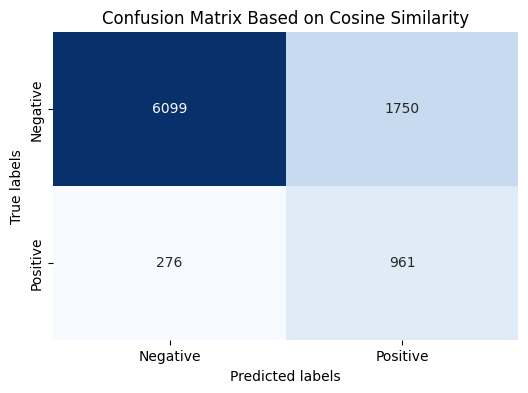

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
confusion = confusion_matrix(y_test,  end_data_cosine['pred_cos_sim'])

plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
#sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Based on Cosine Similarity')
plt.show()


In [ ]:
confusion

array([[6099, 1750],
       [ 276,  961]])

##Analysing Results

In [ ]:
path ="/content/drive/My Drive/probing_llm/test_data_cosine.csv"
end_data_cosine = pd.read_csv(path)

In [ ]:
end_data_cosine.head()

,Unnamed: 0.1,Unnamed: 0,Sentence,Sentence_no,Word,POS,Hypernyms,Label,Numeric_Label,subword,word_index,contextualized_vectors,label embedding,cosine_similarity
0,18503,80221,An index of economic activity drawn from the s...,3285,reading,NN,"['process', 'entity', 'higher_cognitive_proces...",inanimate,0.0,NaN,20.0,"[0.24379123747348785, 0.41305115818977356, 0.3...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.397710
1,34649,151509,A report late yesterday that the Chicago-area ...,6222,country,NN,"['entity', 'group', 'political_unit', 'organiz...",inanimate,0.0,NaN,22.0,"[-0.413516104221344, -0.48201456665992737, -0....","[0.6329518556594849, -0.2643161118030548, -0.0...",0.519500
2,42718,186837,New York Mr. Wanniski 's opportuning of the re...,7673,reasoning,NN,"['process', 'entity', 'thinking', 'higher_cogn...",inanimate,0.0,NaN,45.0,"[0.0072134858928620815, -0.2749762237071991, -...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.558202
3,11269,49676,For a funny thing happened on the way to the r...,2035,Voice,NNP,"['sound_property', 'property', 'entity', 'soun...",inanimate,0.0,NaN,22.0,"[-0.20723582804203033, 0.08257433772087097, 0....","[0.6329518556594849, -0.2643161118030548, -0.0...",0.550653
4,35879,156601,Santa Fe Pacific ( NYSE ; Symbol : SFX ) Busin...,6432,volume,NN,"['measure', 'abstraction', 'entity']",inanimate,0.0,NaN,82.0,"[-0.08732777088880539, 0.33444303274154663, -0...","[0.6329518556594849, -0.2643161118030548, -0.0...",0.439528


In [ ]:
# Noun Classification Analysis
#cosine similarity: {row.cosine_similarity:<5}
# Ensure that we use the same predictions for noun-specific analysis
#test_dat = end_data_cosine.loc[indices_test, :]
test_data = end_data_cosine[["Sentence", "Word", "Numeric_Label", "cosine_similarity", "subword", "contextualized_vectors", "POS"]]

count_correct_noun = 0
count_incorrect_noun = 0
all_noun = 0

for i, row in enumerate(test_data.itertuples()):
    # Retrieve the predicted label for the current test example
    y_pred_word = predicted_labels_np[i]

    # Check if the current word is a noun
    if row.POS in ['NN', 'NNS', 'NNP', 'NNPS']:
        all_noun += 1
        if y_pred_word == row.Numeric_Label:  # Check if the prediction matches the true label
            count_correct_noun += 1
        else:
            print(f"Incorrectly classified: {row.Word:<15}  True label: {row.Numeric_Label:<5}  Predicted label: {y_pred_word:<5} cosine similarity: {row.cosine_similarity:<5}  Sentence: {row.Sentence}")

           # print("Incorrectly classified:", row.Word, "true label:", row.Numeric_Label, "predicted label:", y_pred_word, "----->", row.Sentence)
            count_incorrect_noun += 1

# Results
print("Total nouns:", all_noun)
print("Correctly classified nouns:", count_correct_noun)
print("Incorrectly classified nouns:", count_incorrect_noun)

Incorrectly classified: person           True label: 1.0    Predicted label: 0.0   cosine similarity: 0.5052616671281677  Sentence: As presented by Mr. Chabrol , and played with thin-lipped intensity by Isabelle Huppert , Marie-Louise ( called Marie Latour in the film ) was not a nice person .
Incorrectly classified: giant            True label: 1.0    Predicted label: 0.0   cosine similarity: 0.4489917866908838  Sentence: Italian chemical giant Montedison S.p.A. , through its Montedison Acquisition N.V. indirect unit , began its $ 37-a-share tender offer for all the common shares outstanding of Erbamont N.V. , a maker of pharmaceuticals incorporated in the Netherlands .
Incorrectly classified: Psychiatry       True label: 0.0    Predicted label: 1.0   cosine similarity: 0.3251580633750722  Sentence: William R. Breakey M.D. Pamela J. Fischer M.D. Department of Psychiatry Johns Hopkins University School of Medicine Baltimore A study by Tulane Prof. James Wright says homelessness is due 

**Results**

In total, 9086 nouns were tested. Of these,
- 8888 nouns were correctly classified, and
- 198 nouns were incorrectly classified.

**WordNet**

WordNet incorrectly annotated the following words as examples from the data:
- as inanimate: "Agents," "Publisher," and "founder".

- as animate: "clocks," and "flower."

**BERT**

BERT have incorrectly classified the following words
- as inanimate: "Friends," "Communist", "host"
- as animate: "Psychiatry", "bass"

In [ ]:
# wordnet falsch klassifiziert:
"""
# als nicht belebt klassifiziert

1- Incorrectly classified: agents           True label: 0.0    Predicted label: 1.0    Sentence: And Georgia-Pacific could save money in selling pulp , because the company uses its own sales organization while Nekoosa employs higher-cost agents .
2- Incorrectly classified: publisher        True label: 0.0    Predicted label: 1.0    Sentence: But Ms. Poore , the magazine 's editor and publisher , contends Garbage can survive , at least initially , on subscription revenues .
3- Incorrectly classified: founder          True label: 0.0    Predicted label: 1.0    Sentence: Mr. Stronach , founder and controlling shareholder of Magna , resigned as chief executive officer last year to seek , unsuccessfully , a seat in Canada 's Parliament .
4- Incorrectly classified: Bob              True label: 0.0    Predicted label: 1.0    Sentence: `` Bob has handled the extraordinary growth of the company quite brilliantly , '' said Mr. Newhouse .

#falsch als belebt klassifiziert
1- Incorrectly classified: clocks           True label: 1.0    Predicted label: 0.0    Sentence: The chairs are S-Cargo seats , and a gift shop sells such items as alarm clocks styled like the Pao 's oversized speedometer .
2- Incorrectly classified: flower           True label: 1.0    Predicted label: 0.0    Sentence: The sterilizing gene is expressed just before the pollen is about to develop and it deactivates the anthers of every flower in the plant .

# BERT falsch erkannt
# falsch als nicht belebt erkannt:
1- Incorrectly classified: Friends          True label: 1.0    Predicted label: 0.0    Sentence: Friends told her she was pushing too hard .
2- Incorrectly classified: Communist        True label: 1.0    Predicted label: 0.0    Sentence: Also , a Communist official for the first time said the future of the Berlin Wall could be open to discussion .
3- Incorrectly classified: host             True label: 1.0    Predicted label: 0.0    Sentence: '' A host of electronics firms in California 's Silicon Valley were financed with trading-company venture capital .

# falsch als belebt erkannt:
1- Incorrectly classified: Psychiatry       True label: 0.0    Predicted label: 1.0    Sentence: William R. Breakey M.D. Pamela J. Fischer M.D. Department of Psychiatry Johns Hopkins University School of Medicine Baltimore A study by Tulane Prof. James Wright says homelessness is due to a complex array of problems , with the common thread of poverty .
2- Incorrectly classified: bass             True label: 0.0    Predicted label: 1.0    Sentence: '' Today , the pixie-like clarinetist has mostly dropped the missionary work ( though a touch of the old Tashi still survives ) and now goes on the road with piano , bass , a slide show , and a repertoire that ranges from light classical to light jazz to light pop , with a few notable exceptions .

"""

In [ ]:
print(extract_hypernyms("Agents"))
label_animate(extract_hypernyms("agents"))


['physical_entity', 'causal_agent', 'entity']


'inanimate'

In [ ]:
print(extract_hypernyms("publisher"))
label_animate(extract_hypernyms("publisher"))



['social_group', 'group', 'business', 'entity', 'abstraction', 'organization', 'firm', 'enterprise']


'inanimate'

In [ ]:
print(extract_hypernyms("Flower"))
label_animate(extract_hypernyms("Flower"))


['living_thing', 'entity', 'object', 'whole', 'organism', 'plant', 'physical_entity', 'angiosperm', 'spermatophyte', 'vascular_plant']


'animate'

In [ ]:
print(extract_hypernyms("Federal"))


['living_thing', 'causal_agent', 'entity', 'object', 'whole', 'organism', 'inhabitant', 'Yankee', 'physical_entity', 'person', 'American']


In [ ]:
print(extract_hypernyms("car"))


['whole', 'wheeled_vehicle', 'container', 'conveyance', 'instrumentality', 'entity', 'artifact', 'object', 'motor_vehicle', 'self-propelled_vehicle', 'vehicle', 'physical_entity']


In [ ]:
#richtig:
print(extract_hypernyms("wife"))

['domestic_partner', 'person', 'whole', 'organism', 'relative', 'object', 'adult', 'female', 'entity', 'physical_entity', 'woman', 'spouse', 'living_thing', 'causal_agent']


In [ ]:
print(label_animate(extract_hypernyms("wife")))

animate
